<h3>10.2 特征提取</h3>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from datetime import datetime

In [2]:
trans_train = transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trans_valid = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=trans_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=trans_valid)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


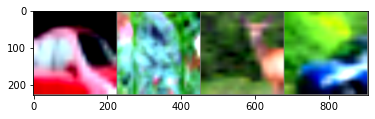

  car   cat  deer   car


In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 显示图像
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images[:4]))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# 使用预训练的模型
net = models.resnet18(pretrained=True)

In [5]:
# 冻结
for param in net.parameters():
    param.requires_grad = False

In [6]:
# 将最后的全连接层改成十分类
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.fc = nn.Linear(512, 10)
# net = torch.nn.DataParallel(net)

In [7]:
# 查看总参数及训练参数
total_params = sum(p.numel() for p in net.parameters())
print('总参数个数:{}'.format(total_params))
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('需训练参数个数:{}'.format(total_trainable_params))

总参数个数:11181642
需训练参数个数:5130


In [8]:
net = net.to(device)

In [9]:
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total

In [10]:
criterion = nn.CrossEntropyLoss()
# 只需要优化最后一层参数
optimizer = torch.optim.SGD(net.fc.parameters(), lr=1e-3, weight_decay=1e-3,momentum=0.9)

In [11]:
def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            im = im.to(device)  # (bs, 3, h, w)
            label = label.to(device) # (bs, h, w)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                im = im.to(device)  # (bs, 3, h, w)
                label = label.to(device) # (bs, h, w)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [12]:
train(net, trainloader, testloader, 20, optimizer, criterion)

Epoch 0. Train Loss: 1.737810, Train Acc: 0.424280, Valid Loss: 0.850917, Valid Acc: 0.715400, Time 00:05:48
Epoch 1. Train Loss: 1.687090, Train Acc: 0.448080, Valid Loss: 0.883290, Valid Acc: 0.704100, Time 00:06:11
Epoch 2. Train Loss: 1.692525, Train Acc: 0.445820, Valid Loss: 0.930059, Valid Acc: 0.687200, Time 00:06:03
Epoch 3. Train Loss: 1.693965, Train Acc: 0.449660, Valid Loss: 0.874421, Valid Acc: 0.703800, Time 00:08:18
Epoch 4. Train Loss: 1.691398, Train Acc: 0.448880, Valid Loss: 1.000717, Valid Acc: 0.672900, Time 00:07:39
Epoch 5. Train Loss: 1.676170, Train Acc: 0.453500, Valid Loss: 1.001782, Valid Acc: 0.664400, Time 00:07:25
Epoch 6. Train Loss: 1.672561, Train Acc: 0.455720, Valid Loss: 0.858725, Valid Acc: 0.712900, Time 00:07:21
Epoch 7. Train Loss: 1.682134, Train Acc: 0.450880, Valid Loss: 0.911487, Valid Acc: 0.699600, Time 00:07:37
Epoch 8. Train Loss: 1.676588, Train Acc: 0.453340, Valid Loss: 0.878762, Valid Acc: 0.709800, Time 00:07:27
Epoch 9. Train Loss

<h3>10.3 数据增强</h3>

In [13]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

(600, 600, 3)


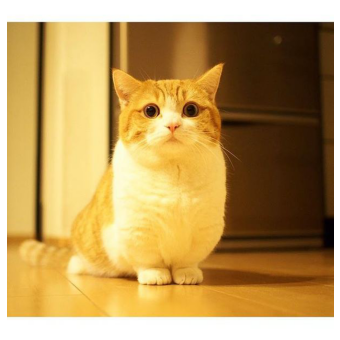

In [14]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example image
x = Image.open('data/cat/cat.jpg')
print(np.array(x).shape)
imshow(x)

In [15]:
def imshow_tensor(image, ax=None, title=None):
    """可视化张量(Tensor)"""

    if ax is None:
        fig, ax = plt.subplots()

    # 把第3个维度设置为颜色通道
    image = image.numpy().transpose((1, 2, 0))

    # 反转预处理步骤
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # 剪切图像像素值
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

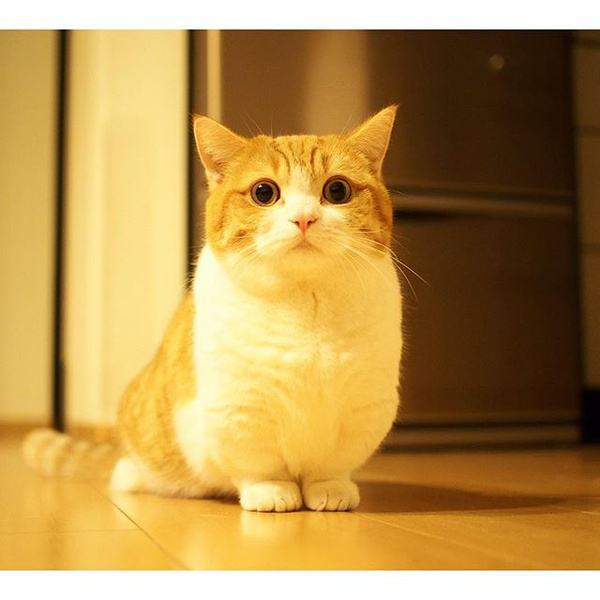

In [16]:
# 读入一张图片
im = Image.open('data/cat/cat.jpg')
im

原图片大小: (600, 600)
缩放后大小: (200, 100)


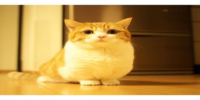

In [17]:
# 随机比例缩放主要使用的是 torchvision.transforms.Resize()
# 比例缩放
from torchvision import transforms as trans
print('原图片大小: {}'.format(im.size))
new_im = trans.Resize((100, 200))(im)
print('缩放后大小: {}'.format(new_im.size))
new_im

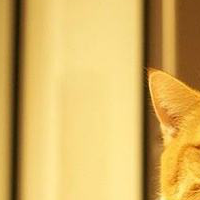

In [18]:
# 随机位置截取能够提取出图片中局部的信息，使得网络接受的输入具有多尺度的特征，所以能够有较好的效果。
# 在 torchvision 中主要有下面两种方式，一个是 torchvision.transforms.RandomCrop()，
# 传入的参数就是截取出的图片的长和宽，对图片在随机位置进行截取；第二个是 torchvision.transforms.CenterCrop()，
# 同样传入介曲初的图片的大小作为参数，会在图片的中心进行截取
# 随机裁剪出 100 x 100 的区域
random_im1 = trans.RandomCrop(200)(im)
random_im1

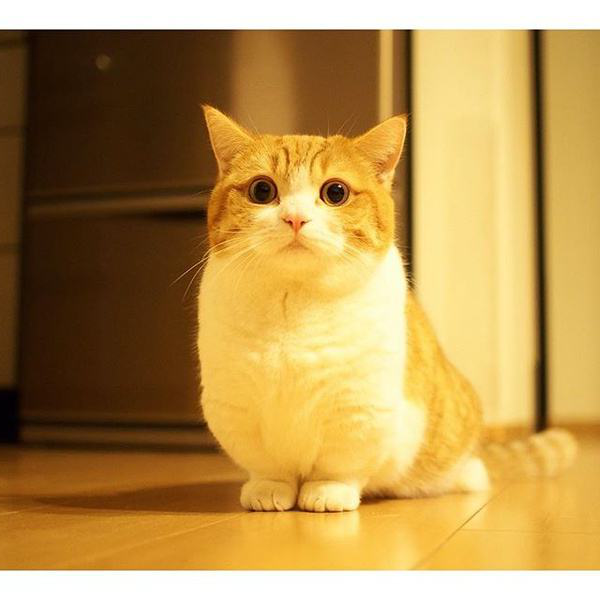

In [19]:
# 我们将它翻转一下，它仍然是一张猫，但是图片就有了更多的多样性，所以随机翻转也是一种非常有效的手段。
# 在 torchvision 中，随机翻转使用的是 torchvision.transforms.RandomHorizontalFlip()
# 和 torchvision.transforms.RandomVerticalFlip()
# 随机水平翻转
h_filp = trans.RandomHorizontalFlip()(im)
h_filp

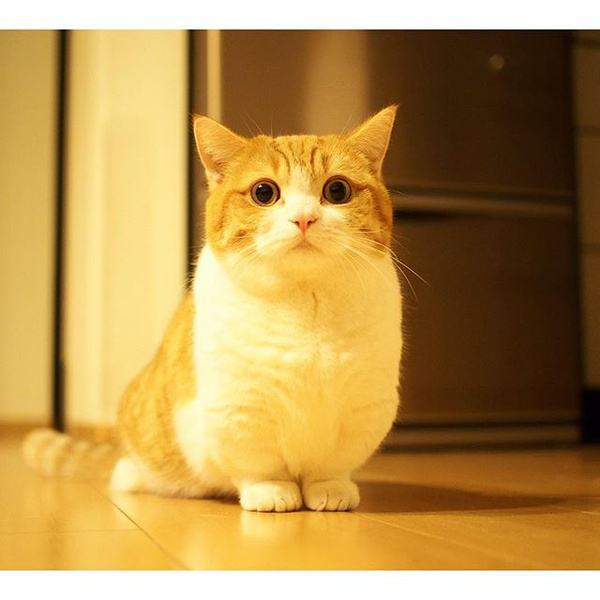

In [20]:
# 随机竖直翻转
v_flip = trans.RandomVerticalFlip()(im)
v_flip

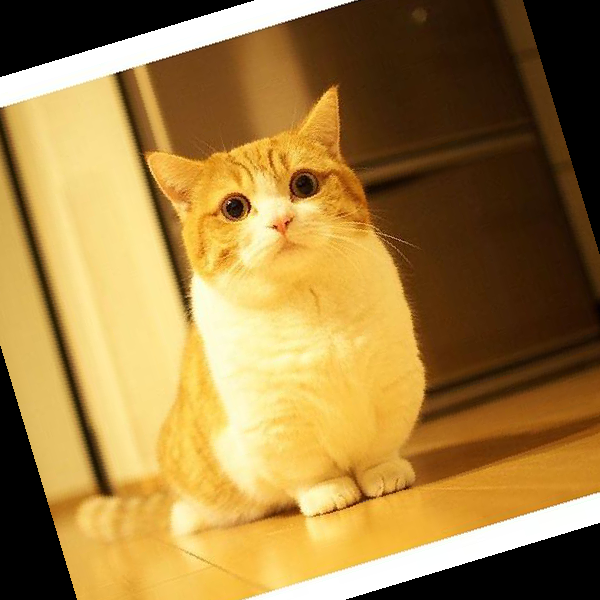

In [21]:
#一些角度的旋转仍然是非常有用的数据增强方式，在 torchvision 中，
# 使用 torchvision.transforms.RandomRotation() 来实现
rot_im = trans.RandomRotation(45)(im)
rot_im

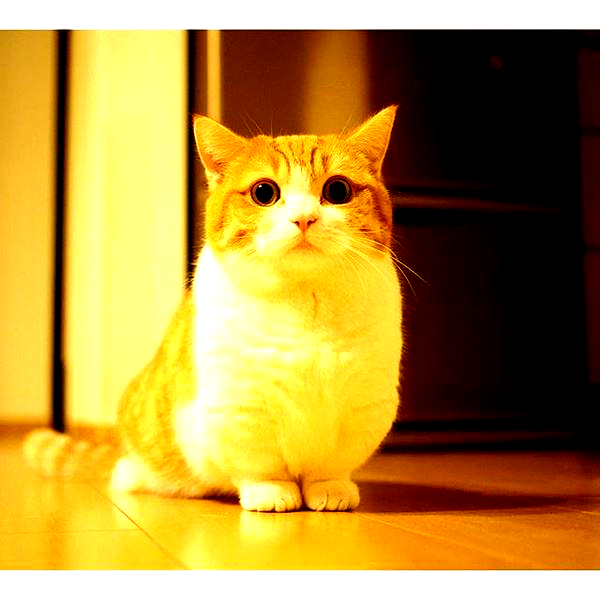

In [22]:
# 除了形状变化外，颜色变化又是另外一种增强方式，其中可以设置亮度变化，对比度变化和颜色变化等，
# 在 torchvision 中主要使用 torchvision.transforms.ColorJitter() 来实现的，第一个参数就是亮度的比例，
# 第二个是对比度，第三个是饱和度，第四个是颜色
# 对比度
contrast_im = trans.ColorJitter(contrast=1)(im) # 随机从 0 ~ 2 之间对比度变化，1 表示原图
contrast_im

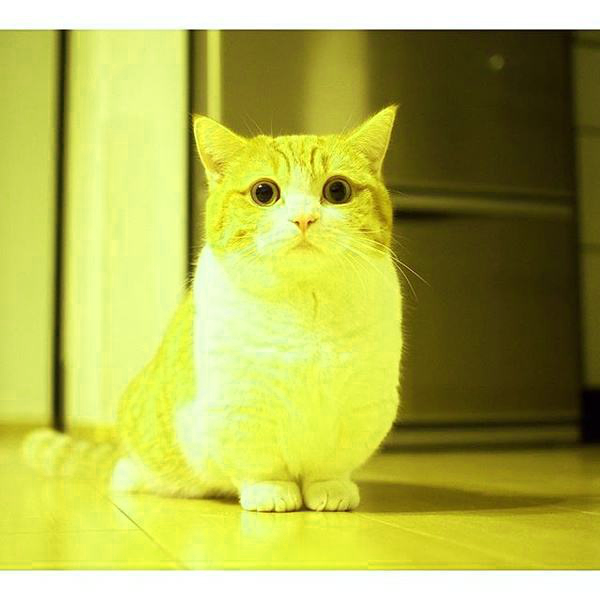

In [23]:
# 颜色
color_im = trans.ColorJitter(hue=0.5)(im) # 随机从 -0.5 ~ 0.5 之间对颜色变化
color_im

In [24]:
im_aug = trans.Compose([
    trans.Resize(200),
    trans.RandomHorizontalFlip(),
    trans.RandomCrop(96),
    trans.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5)
])

(0.0, 1.0, 0.0, 1.0)

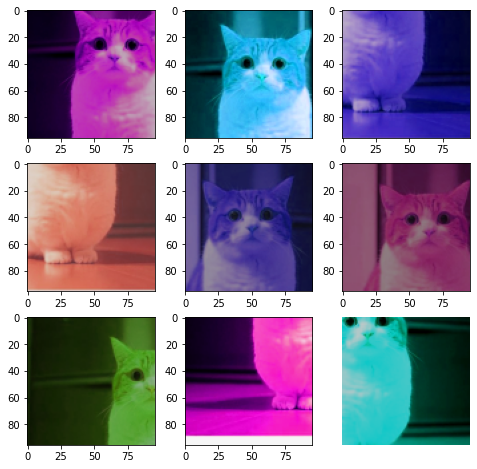

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
nrows = 3
ncols = 3
figsize = (8, 8)
_, figs = plt.subplots(nrows, ncols, figsize=figsize)
plt.axis('off')
for i in range(nrows):
    for j in range(ncols):
        figs[i][j].imshow(im_aug(im))
plt.show()
